<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2025/blob/main/notebooks/es_10.4/AML_Fis2025_E6_UncertaintyQuantificationDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2024-25

## Hands-on session 6: Uncertainty Quantification on Deep Neural Networks#


**Scope:** compare different uncertainty quantification methods

**Tasks:** <p>
given a 1D dataset describing a simulation of a spread-out Bragg peak in proton therapy (see first cell code):

1.   train a **Bayesian-NN based on variational Inference** to solve the 1D regression task;
2.   implement a **deep ensamble method** based on a dsiscriminatve ANN, with the same archietcture as the BNN, to estimate the uncertainty and compare with the Bayesian result in terms of uncertainty bounds and computational cost;
3.   take the first ANN model trained in point 2 as a black-box, and use **conformal prediction** to assess the model uncertainty. Compare results with previous methods.

**Dataset:** simulation of a spread-out Bragg peak in proton therapy, can be uploaded from the github page of the course [link](https://github.com/stefanogiagu/corso_AML_2025/tree/main/notebooks/es_10.4) (very small size 12kB)

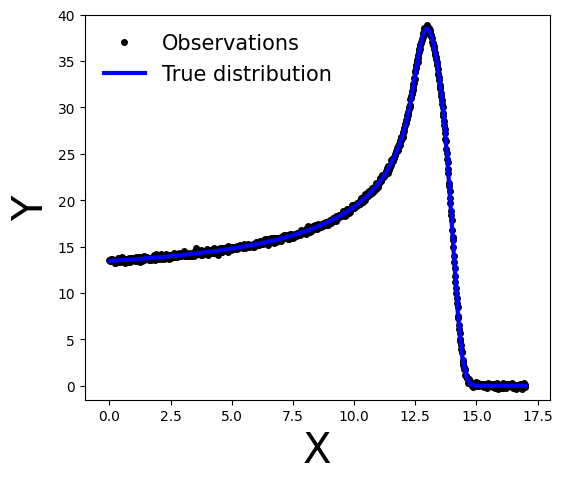

In [ ]:
# Read and plot the dataset (1000 points 1D)

import numpy as np
import matplotlib.pyplot as plt

myfile = np.load('Bragg_dataset.npz')

x = np.array(myfile['X'])            #depth
y_true = np.array(myfile['Y_true'])  #deposited dose

# add noise to the data

np.random.seed(42) # random seed for reproducibility

noise_scale = 0.15
noise = noise_scale * np.random.randn(x.shape[0]) #gaussian noise

y_obs = y_true + noise               #observed data

# Set plot limits and labels
xlims = [-1.0, 18.0]
ylims = [-1.5, 40.0]

# Create function and observed data plot
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(x, y_obs, 'ko', markersize=4, label="Observations")
ax.plot(x, y_true, 'b-', linewidth=3, label="True distribution")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=0, fontsize=15, frameon=False)

plt.show()

# Train a Bayesian-DNN model (a simple MLP) to predict the values of the function

In [ ]:
#install torchbnn (https://github.com/Harry24k/bayesian-neural-network-pytorch)
!pip install torchbnn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [ ]:
# Bayesian DNN model: MLP with two hidden layers with hid_dim neurons and ReLU activation

# simple 200 neurons two layers dense NN with bayesian weights with nornmal priors

BDNN = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=200),   #first hidden layer
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200), #second hidden layer
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=1),   #output layer
)

In [ ]:
# loss is the sum of a recontruction loss (MSE) + kl_weight*KL divergence

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)

# weight of the KL term in the total loss
kl_weight = 1.0

# adam optimiser
optimizer = optim.Adam(BDNN.parameters(), lr=0.01)

In [ ]:
# training loop

import tqdm
from tqdm.auto import trange

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x.reshape(-1, 1)).float()
y_train = torch.from_numpy(y_obs).float()

progress_bar = trange(6000) #quick&dirty: batch=sample-size and no validation

for _ in progress_bar:
    pre = BDNN(x_train)
    mse = mse_loss(pre.flatten(), y_train)
    kl = kl_loss(BDNN)
    loss = mse + kl_weight*kl
    lv = loss.item()
    progress_bar.set_postfix({'loss':lv})

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('\n Last step MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

  0%|          | 0/6000 [00:00<?, ?it/s]


 Last step MSE : 0.36, KL : 1.23


In [ ]:
# Now we can use the model in prediction

x_test = np.linspace(-1.,18., 4000).reshape(-1, 1)
x_test_pt = torch.tensor(x_test).float()
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = BDNN(x_test_pt)
    y_pred_list.append(y_pred.data.numpy())

y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

100%|██████████| 500/500 [00:05<00:00, 85.88it/s]


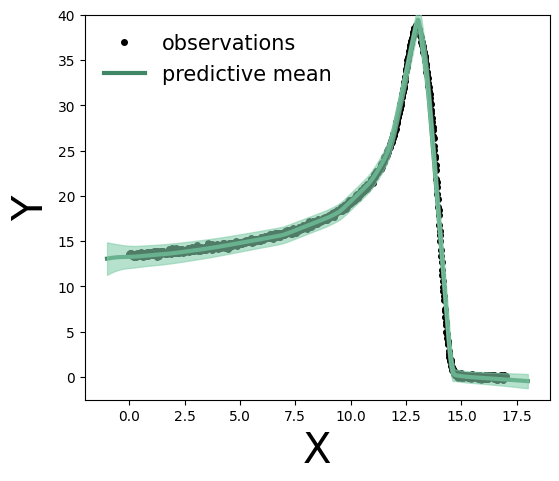

In [ ]:
# plot results

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test.ravel(), y_mean - 1.96 * y_sigma, y_mean + 1.96 * y_sigma, alpha=0.6, color='#86cfac', zorder=5) #95% bands

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

## Batesian NN Using Pyro Library example

In [ ]:
#install pyro library
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 829.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# BNN trained with variational Inference

# see: http://pyro.ai/examples/intro_long.html#Inference-in-Pyro for details in Pyro usage

# Bayesian DNN Model: MLP with two hidden layers with hid_dim neurons and ReLU activation

# gaussian priors on the weights: N(mu=0, sigma=1*I)
# prior for sigma: Uniform(0.,1.)


import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class SimpleBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=200, prior_scale=1.0):
        super().__init__()

        self.activation = nn.ReLU()

        # PyroModule is a subclass of nn.torch.Module with atributes that can be modified by Pyro
        # PyroMdule[nn.Linear] create a new class that subclasses PyroModule and and torch Linear: eg a Bayesian Linear layer
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # first hidden layer [in_dim --> hid_dim]
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim) # second hidden layer [hid_dim --> hid_dim]
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim) # output hidden layer [hid_dim --> out_dim]

        # Set layer parameters as random variables (this makes the layers Bayesian) by using PyroSample which allows to define a prior
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

        # NOTE: while trorch tensors have only one single shape attribute (.shape), Pyro Distributions have two shape attributes (.batch_shaoe and .event_shape)
        # Indices over .batch_shape denote conditionally independent random variables, whereas indices over .event_shape denote dependent random variables (ie one draw from a distribution).
        # In standard Pyro usage dimensions are typically declarted as dependent even though they will be in fact independent, postponing later on to define if the dimensions will be dependent like in
        # a MulitivariateNormal distribution for example or independent (like in this example)

    def forward(self, x, y=None):
        x = x.reshape(-1, 1) #reshape input feature tensor from (batch) to (batch,1)
        x = self.activation(self.layer1(x)) #apply first layer + activation transform
        x = self.activation(self.layer2(x)) #apply first layer + activation transform

        mu = self.layer3(x).squeeze() #apply second layer (no activation)
        #sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))

        # Sampling model (pyro.plate allows to define dimensions as conditytionally independent as in our model)
        # Remember in Pyro samples have shape batch_shape + event_shape, whereas .log_prob(x) values have shape batch_shape,
        # pyro.plate allows to take care of that
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        return mu

In [ ]:
# train model with Variational Inference
# for more details : http://pyro.ai/examples/intro_long.html
# stochastic variational inference with the variational density q by using a normal probability density with a diagonal covariance matrix

from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store() #set the initial pyro parameters store

model = SimpleBNN()

# "guide" in the pyro lingo is the variational distribution q. AutoDiagonalNormal is normal q with diagonal cov. matrix
# https://docs.pyro.ai/en/stable/infer.autoguide.html
mean_field_guide = AutoDiagonalNormal(model)# mean field, each variable in independent (i.e diagonal correlation matrix)

optimizer = pyro.optim.Adam({"lr": 0.01})

# SVI is the main stochastic variation inference module than encpasule the machinery for doing variational inference
# user needs to provide three things: the model, the guide, and an optimizer
# the ELBO loss is called Trace_ELBO()

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store() #set the initial pyro parameters store

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x).float()
y_train = torch.from_numpy(y_obs).float()

# training
num_epochs = 30000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/30000 [00:00<?, ?it/s]

In [ ]:
# reduce lr and continue training ...
optimizer = pyro.optim.Adam({"lr": 0.001})
svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())

num_epochs = 10000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Now we can use the model in prediction
from pyro.infer import Predictive

predictive = Predictive(model, guide=mean_field_guide, num_samples=500)

# test the model over the full function domain range
x_test = torch.linspace(-1.0, 18.0, 3000)
preds = predictive(x_test)

In [ ]:
print(model(x_test).shape)
print(preds['obs'].detach().numpy().shape) # model response given a sample of the q distribution for each point in x , 500 samples

torch.Size([3000])
(500, 3000)


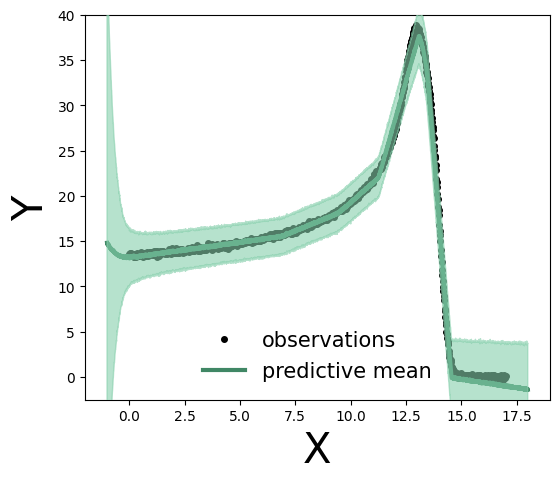

In [ ]:
y_pred = preds['obs'].T.detach().numpy().mean(axis=1) #predictions mean
y_std = preds['obs'].T.detach().numpy().std(axis=1)   #predictions std. dev.

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
ax.fill_between(x_test, y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, alpha=0.6, color='#86cfac', zorder=5) #95% bands

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

# Deep Ensamble Method

Train the same MLP multiple time with different initializations of weigth matrices, use the distribution of the models' predictions for a given input $x$ to estimate mean and std. dev. prediction.

In [ ]:
# The non-Bayesian equivalent of the simple BNN model used before
class SimpleNN(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=200):
        super().__init__()

        self.activation = nn.ReLU()
        self.layer1 = nn.Linear(in_dim, hid_dim)   # Input to hidden layer
        self.layer2 = nn.Linear(hid_dim, hid_dim)  # Hidden to Hidden
        self.layer3 = nn.Linear(hid_dim, out_dim)  # Hidden to output layer

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x).squeeze()
        return x

In [ ]:
# train loop function

def train_model(model, x, y):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    progress_bar = trange(3000)
    for _ in progress_bar:
        optimizer.zero_grad()
        loss = criterion(y, model(x))
        progress_bar.set_postfix(loss=f'{loss:.3f}')
        loss.backward()
        optimizer.step()
    return model

In [ ]:
# a single ANN result

from tqdm.auto import trange

# Convert data to PyTorch tensors
x_train = torch.from_numpy(x.reshape(-1, 1)).float()
y_train = torch.from_numpy(y_obs).float()
x_test = np.linspace(-1.,18., 4000).reshape(-1, 1)
x_test_pt = torch.tensor(x_test).float()

model2 = SimpleNN()
model2 = train_model(model2, x_train, y_train)

# test it
preds = model2(x_test_pt).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

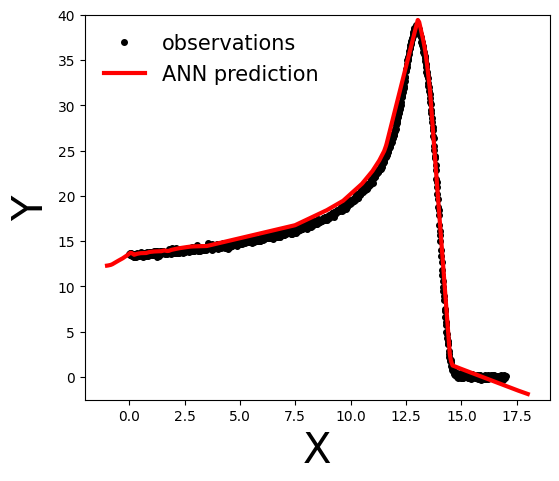

In [ ]:
y_pred = preds

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_pred, 'r-', linewidth=3, label="ANN prediction")

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

In [ ]:
# Deep Ensamble: eg train an ensamble of SimpleNN models each one initalized with different random wights and biases

ensemble_size = 10

ensemble = [SimpleNN() for _ in range(ensemble_size)]

for model2 in ensemble:
    train_model(model2, x_train, y_train)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# calculate predictions

ens_preds = [np.array(model2(x_test_pt).clone().detach().numpy()) for model2 in ensemble]

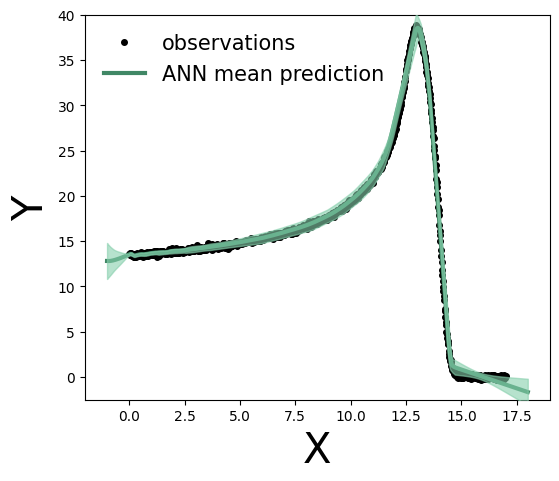

In [ ]:
# plot uncertainty bands

y_pred = np.array(ens_preds)
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_mean, '-', linewidth=3, color="#408765", label="ANN mean prediction")
ax.fill_between(x_test.ravel(), y_mean - 1.96 * y_std, y_mean + 1.96 * y_std, alpha=0.6, color='#86cfac', zorder=5) #95% bounds

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

# UQ using Conformal Prediction

* create a calibration dataset (statistically idependent from the training and test set)
* calculate the 95% quantiles
* plot predictions and errro bars for the test set

In [ ]:
# split the traing dataset in real training set (80%) and in the calibrations set (20%)

# equally spaced indexes for 20% of the x_train events
cal_idx = np.arange(len(x_train), step=1/0.2, dtype=np.int64)

# selection mask
mask = np.zeros(len(x_train), dtype=bool)
mask[cal_idx] = True

x_cali, y_cali = x_train[mask], y_train[mask]
x_train2, y_train2 = x_train[~mask], y_train[~mask]

print(x_train2.shape)
print(x_cali.shape)

torch.Size([800, 1])
torch.Size([200, 1])


In [ ]:
# Train one of the previous models used in the Ensamble case

model3 = SimpleNN()
model3 = train_model(model3, x_train2, y_train2)

# test it
preds = model3(x_test_pt).clone().detach().numpy()

  0%|          | 0/3000 [00:00<?, ?it/s]

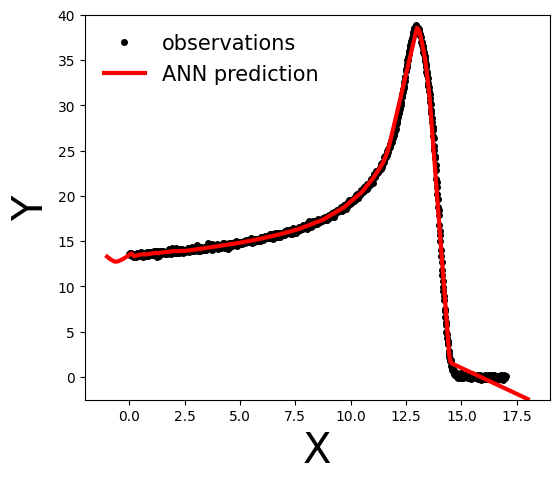

In [ ]:
y_pred = preds

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_pred, 'r-', linewidth=3, label="ANN prediction")

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

In [ ]:
# perform the conformal prediction procedure

#1 compute calibration residuals |true - predicted| = Score
y_cali_preds = model3(x_cali).clone().detach()
resid = torch.abs(y_cali - y_cali_preds).numpy()

#2 compute (1-alpha)-quantile (alpha = 5%)of score: P(x<=q) = 1-alpha and P(x>=q) = alpha
alpha = 0.05
n = len(x_cali)
q_val = np.ceil((1 - alpha) * (n + 1)) / n
q = np.quantile(resid, q_val)

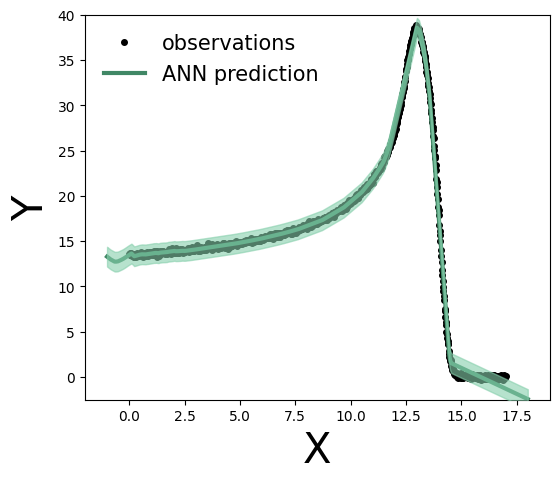

In [ ]:
# plot results

y_pred = preds

fig, ax = plt.subplots(figsize=(6, 5))
xlims = [-2.0, 19.0]
ylims = [-2.5, 40.0]
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

ax.plot(x, y_obs, 'ko', markersize=4, label="observations")
ax.plot(x, y_obs, 'ko', markersize=3)
ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="ANN prediction")
ax.fill_between(x_test.ravel(), y_pred - q, y_pred + q, alpha=0.6, color='#86cfac', zorder=5)

plt.legend(loc=0, fontsize=15, frameon=False)
plt.show()

**To do for test:**
* try to implement similar procedures for a classification task instaed of a regressione one
* try to implement a deep drop out method
* play with the pyro implementation